In [12]:
!pip install polars

In [8]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# こちらの共有フォルダにアクセスしてください
# https://drive.google.com/drive/folders/1EyZuU3SRCnQ57VkpTR3_a7sOFVEl6Uz5

prefix_files = '/content/drive/Shareddrives/ai_lab_2023'

In [16]:
import re
import requests
import polars as pl
from fugashi import Tagger
from gensim.corpora import Dictionary, MmCorpus
from gensim import models
from tqdm import tqdm

class LivedoorCorpus():
    def __init__(self, csv_path):
        self.df = pl.read_csv(csv_path)

        # 全角半角文字以外（記号と数字）を正規表現を使って除去
        pattern = r"[^\u3040-\u30ff\u3400-\u4dbf\u4e00-\u9fff\uf900-\ufaff\u20000-\u2ffff\sa-zA-Z]"
        self.raw_documents = [re.sub(pattern, "", text) for text in self.df["DOCUMENT"]]
        # Mecabで分かち書きして、単語に分割
        self.raw_documents = [Tagger('-Owakati').parse(text).split() for text in tqdm(self.raw_documents)]
        # ストップワードの除去
        self.raw_documents = self._rm_stopwords()
        # 1文字は除去
        self.raw_documents = [[word for word in text if len(word) > 1]for text in self.raw_documents]

        self.dictionary = Dictionary(self.raw_documents)

        self.bow = [ self.dictionary.doc2bow(text) for text in tqdm(self.raw_documents)]
    
    def reset_dict_corpus(self):
        self.dictionary = Dictionary(self.raw_documents)
        self.bow = [ self.dictionary.doc2bow(text) for text in self.raw_documents]

    def print_stats(self):
        print(f"文書数: {self.dictionary.num_docs}, " + f"語彙数: {len(self.dictionary)}")

    def dict_top_n(self, top_n: int):
        most_frequent_ids = (v for v in self.dictionary)
        most_frequent_ids = sorted(most_frequent_ids, key=self.dictionary.dfs.get, reverse=True)
        most_frequent_ids = most_frequent_ids[:top_n]
        return [self.dictionary[idx] for idx in most_frequent_ids]
        
    def _rm_stopwords(self):
        # ストップワードの準備
        stopwords_url = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
        r = requests.get(stopwords_url)
        tmp = r.text.split('\r\n')
        stopwords = []
        for i in range(len(tmp)):
            if len(tmp[i]) < 1:
                continue
            stopwords.append(tmp[i])

        return [[word for word in text if not word in stopwords]for text in self.raw_documents]

In [18]:
# colabでは処理重たいので、こちらのファイルを使います。
import pickle
with open(f'{prefix_files}/corpus.pkl', 'rb') as f:
    corpus = pickle.load(f)
dictionary = Dictionary.load(f'{prefix_files}/livedoor.dict')
doc_train = MmCorpus(f'{prefix_files}/doc_train.mm')
doc_test = MmCorpus(f'{prefix_files}/doc_test.mm')

2023-01-28 00:33:58,561 : INFO : loading Dictionary object from livedoor.dict
2023-01-28 00:33:58,571 : DEBUG : {'uri': 'livedoor.dict', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'compression': 'infer_from_extension', 'transport_params': None}
2023-01-28 00:33:58,582 : INFO : Dictionary lifecycle event {'fname': 'livedoor.dict', 'datetime': '2023-01-28T00:33:58.582899', 'gensim': '4.3.0', 'python': '3.9.6 (default, Sep 26 2022, 11:37:49) \n[Clang 14.0.0 (clang-1400.0.29.202)]', 'platform': 'macOS-12.5.1-arm64-arm-64bit', 'event': 'loaded'}
2023-01-28 00:33:58,584 : DEBUG : {'uri': 'doc_train.mm.index', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'compression': 'infer_from_extension', 'transport_params': None}
2023-01-28 00:33:58,589 : INFO : loaded corpus index from doc_train.mm.index
2023-01-28 00:33:58,590 : INFO : initializing cython corpus 

# トピックモデル（LDA）の学習
- トピック数がハイパーパラメタです。
- トピック数が2~6個であるモデルをそれぞれ学習させます
- 上記のモデルで指標が最も良いモデルを選びます。

モデルの指標はパープレキシティといい、予測単語の候補数（どれだけ絞り込めているか）を表します。低い方が良い指標です。

In [9]:
topic_range = range(2, 7)

def calc_perplexity(m, c):
    import numpy as np
    return np.exp(-m.log_perplexity(c))

def search_model(corpus_train, corpus_test):
    most = [1.0e6, None]
    print(f"dataset: training/test = {len(corpus_train)}/{len(corpus_test)}")

    for t in topic_range:
        m = models.LdaModel(corpus=corpus_train, id2word=dictionary, num_topics=t, iterations=500, passes=5)
        # m = models.LdaModel(corpus=corpus_train, id2word=dictionary, num_topics=t, iterations=500, passes=5)
        p1 = calc_perplexity(m, corpus_train)
        p2 = calc_perplexity(m, corpus_test)
        print(f"{t}: perplexity is {p1}/{p2}")
        
        if p2 < most[0]:
            most[0] = p2
            most[1] = m
    
    return most[0], most[1]

perplexity, model = search_model(doc_train, doc_test)
print(f"Best model: topics={model.num_topics}, perplexity={perplexity}")

2023-01-27 10:17:27,654 : INFO : using symmetric alpha at 0.5
2023-01-27 10:17:27,655 : INFO : using symmetric eta at 0.5
2023-01-27 10:17:27,657 : INFO : using serial LDA version on this node
2023-01-27 10:17:27,662 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 5893 documents, updating model once every 2000 documents, evaluating perplexity every 5893 documents, iterating 500x with a convergence threshold of 0.001000
2023-01-27 10:17:27,663 : DEBUG : {'uri': 'doc_train.mm', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'compression': 'infer_from_extension', 'transport_params': None}
2023-01-27 10:17:27,745 : INFO : PROGRESS: pass 0, at document #2000/5893
2023-01-27 10:17:27,745 : DEBUG : performing inference on a chunk of 2000 documents


dataset: training/test = 5893/1474


2023-01-27 10:17:32,164 : DEBUG : 981/2000 documents converged within 500 iterations
2023-01-27 10:17:32,164 : DEBUG : updating topics
2023-01-27 10:17:32,165 : INFO : merging changes from 2000 documents into a model of 5893 documents
2023-01-27 10:17:32,169 : INFO : topic #0 (0.500): 0.005*"できる" + 0.004*"更新" + 0.004*"より" + 0.004*"でき" + 0.004*"まで" + 0.004*"ソフト" + 0.004*"映画" + 0.003*"ソフトウェア" + 0.003*"バンク" + 0.003*"関連"
2023-01-27 10:17:32,169 : INFO : topic #1 (0.500): 0.005*"日本" + 0.005*"できる" + 0.005*"たい" + 0.004*"って" + 0.004*"あり" + 0.003*"だけ" + 0.003*"まで" + 0.003*"記事" + 0.003*"なく" + 0.003*"だろう"
2023-01-27 10:17:32,170 : INFO : topic diff=1.326034, rho=1.000000
2023-01-27 10:17:32,254 : INFO : PROGRESS: pass 0, at document #4000/5893
2023-01-27 10:17:32,255 : DEBUG : performing inference on a chunk of 2000 documents
2023-01-27 10:17:34,058 : DEBUG : 1965/2000 documents converged within 500 iterations
2023-01-27 10:17:34,058 : DEBUG : updating topics
2023-01-27 10:17:34,059 : INFO : merg

2: perplexity is 3454.2014765609965/4209.363831908598


2023-01-27 10:17:52,319 : DEBUG : 1104/2000 documents converged within 500 iterations
2023-01-27 10:17:52,319 : DEBUG : updating topics
2023-01-27 10:17:52,320 : INFO : merging changes from 2000 documents into a model of 5893 documents
2023-01-27 10:17:52,321 : INFO : topic #0 (0.333): 0.004*"更新" + 0.004*"できる" + 0.004*"って" + 0.004*"日本" + 0.004*"あり" + 0.004*"たい" + 0.004*"でき" + 0.004*"なく" + 0.004*"だけ" + 0.004*"女性"
2023-01-27 10:17:52,322 : INFO : topic #1 (0.333): 0.006*"ソフト" + 0.005*"バンク" + 0.004*"日本" + 0.004*"できる" + 0.004*"たい" + 0.004*"映画" + 0.004*"記事" + 0.003*"まで" + 0.003*"あり" + 0.003*"また"
2023-01-27 10:17:52,322 : INFO : topic #2 (0.333): 0.005*"できる" + 0.004*"まで" + 0.004*"日本" + 0.004*"より" + 0.004*"たい" + 0.003*"記事" + 0.003*"アプリ" + 0.003*"スマート" + 0.003*"発売" + 0.003*"映画"
2023-01-27 10:17:52,323 : INFO : topic diff=1.520790, rho=1.000000
2023-01-27 10:17:52,408 : INFO : PROGRESS: pass 0, at document #4000/5893
2023-01-27 10:17:52,408 : DEBUG : performing inference on a chunk of 2000 docu

3: perplexity is 3199.6898210368668/4124.50109969821


2023-01-27 10:18:12,773 : DEBUG : 1118/2000 documents converged within 500 iterations
2023-01-27 10:18:12,774 : DEBUG : updating topics
2023-01-27 10:18:12,775 : INFO : merging changes from 2000 documents into a model of 5893 documents
2023-01-27 10:18:12,777 : INFO : topic #0 (0.250): 0.006*"ソフト" + 0.006*"バンク" + 0.005*"女性" + 0.005*"映画" + 0.004*"記事" + 0.004*"たい" + 0.003*"だけ" + 0.003*"できる" + 0.003*"関連" + 0.003*"情報"
2023-01-27 10:18:12,777 : INFO : topic #1 (0.250): 0.006*"できる" + 0.005*"日本" + 0.004*"まで" + 0.004*"より" + 0.004*"たい" + 0.003*"映画" + 0.003*"たり" + 0.003*"スマート" + 0.003*"だっ" + 0.003*"なく"
2023-01-27 10:18:12,778 : INFO : topic #2 (0.250): 0.004*"って" + 0.004*"たい" + 0.004*"あり" + 0.004*"更新" + 0.004*"できる" + 0.004*"いい" + 0.004*"日本" + 0.004*"でき" + 0.004*"まで" + 0.004*"アプリ"
2023-01-27 10:18:12,779 : INFO : topic #3 (0.250): 0.005*"できる" + 0.004*"機能" + 0.004*"日本" + 0.004*"より" + 0.004*"まで" + 0.003*"だろう" + 0.003*"情報" + 0.003*"たい" + 0.003*"だけ" + 0.003*"対応"
2023-01-27 10:18:12,779 : INFO : topic

4: perplexity is 3093.196636751317/4156.759133575097


2023-01-27 10:18:33,017 : DEBUG : 1163/2000 documents converged within 500 iterations
2023-01-27 10:18:33,018 : DEBUG : updating topics
2023-01-27 10:18:33,019 : INFO : merging changes from 2000 documents into a model of 5893 documents
2023-01-27 10:18:33,021 : INFO : topic #0 (0.200): 0.007*"って" + 0.007*"日本" + 0.005*"けど" + 0.004*"まで" + 0.004*"なく" + 0.004*"いい" + 0.003*"あり" + 0.003*"たい" + 0.003*"だけ" + 0.003*"たら"
2023-01-27 10:18:33,022 : INFO : topic #1 (0.200): 0.006*"できる" + 0.004*"より" + 0.004*"日本" + 0.004*"記事" + 0.004*"対応" + 0.004*"たい" + 0.003*"発売" + 0.003*"スマート" + 0.003*"関連" + 0.003*"なく"
2023-01-27 10:18:33,022 : INFO : topic #2 (0.200): 0.006*"できる" + 0.005*"アプリ" + 0.004*"でき" + 0.004*"映画" + 0.004*"たい" + 0.004*"記事" + 0.004*"機能" + 0.004*"まで" + 0.003*"あり" + 0.003*"だけ"
2023-01-27 10:18:33,023 : INFO : topic #3 (0.200): 0.005*"たい" + 0.004*"女性" + 0.004*"できる" + 0.004*"日本" + 0.004*"だろう" + 0.004*"まで" + 0.004*"映画" + 0.004*"なら" + 0.004*"でき" + 0.003*"仕事"
2023-01-27 10:18:33,023 : INFO : topic #4

5: perplexity is 2975.992851365988/4155.09564738701
Best model: topics=3, perplexity=4124.50109969821


### トピック間の距離
トピックは単語分布で表現されます。
確率分布であるので、KLダイバージェンスによって距離を測ることができます。

2023-01-27 10:57:47,740 : DEBUG : matplotlib data path: /Users/hajime/projects/ai_lab/.env/lib/python3.9/site-packages/matplotlib/mpl-data
2023-01-27 10:57:47,743 : DEBUG : CONFIGDIR=/Users/hajime/.matplotlib
2023-01-27 10:57:47,745 : DEBUG : interactive is False
2023-01-27 10:57:47,745 : DEBUG : platform is darwin
2023-01-27 10:57:47,779 : DEBUG : CACHEDIR=/Users/hajime/.matplotlib
2023-01-27 10:57:47,780 : DEBUG : Using fontManager instance from /Users/hajime/.matplotlib/fontlist-v330.json
2023-01-27 10:57:47,889 : DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-01-27 10:57:47,890 : DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-01-27 10:57:47,892 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2023-01-27 10:57:47,892 : DEBUG : findfont: score(FontEntry(fname='/Users/hajime/projects/ai_lab/.env/lib/python3.9/site-packages/matplotlib/mpl-data/font

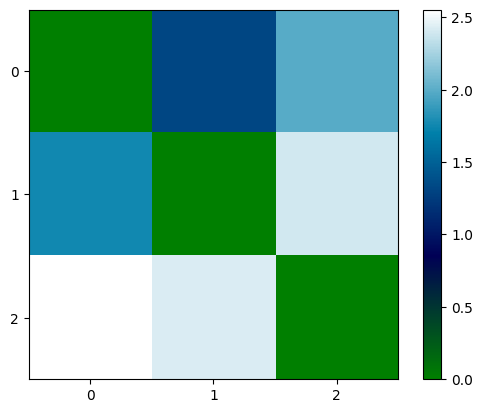

In [17]:
import numpy as np
import matplotlib.pylab as plt

def calc_topic_distances(m, topic):
    
    def kldiv(p, q):
        distance = np.sum(p * np.log(p / q))
        return distance
    
    # get probability of each words
    # https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/models/ldamodel.py#L1186
    t = m.state.get_lambda()
    for i, p in enumerate(t):
        t[i] = p / p.sum()
    

    base = t[topic]
    distances = [(i_p[0], kldiv(base, i_p[1])) for i_p in enumerate(t) if i_p[0] != topic]
    return distances

def plot_distance_matrix(m):
    
    # make distance matrix
    mt = []
    for i in range(m.num_topics):
        d = calc_topic_distances(m, i)
        d.insert(i, (i, 0))  # distance between same topic
        d = [_d[1] for _d in d]
        mt.append(d)

    mt = np.array(mt)
    
    # plot matrix
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_aspect("equal")
    plt.imshow(mt, interpolation="nearest", cmap=plt.cm.ocean)
    plt.yticks(range(mt.shape[0]))
    plt.xticks(range(mt.shape[1]))
    plt.colorbar()
    plt.show()

plot_distance_matrix(model)

### 文書ごとのトピックの分布
トピックモデルでは、文書内のトピックの割合を推定しています。それを可視化してみましょう。

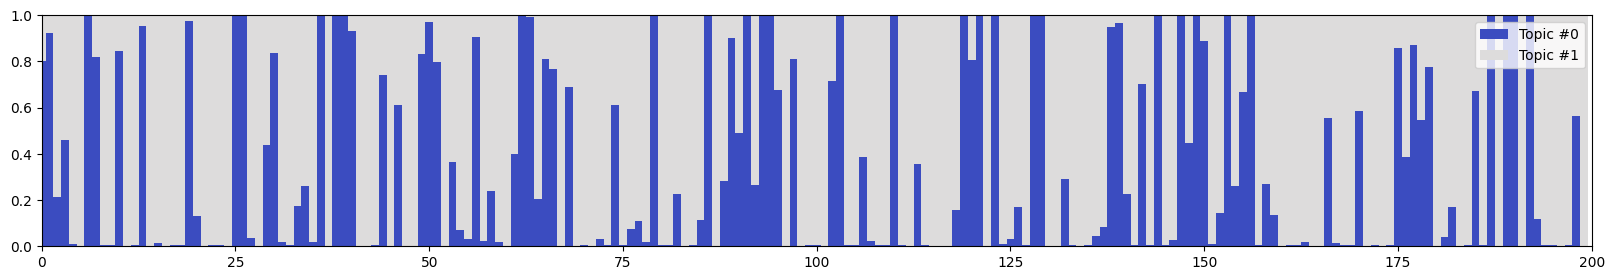

In [19]:
import random
import numpy as np
import matplotlib.pylab as plt

def show_document_topics(c, m, sample_size=200, width=1):

    # make document/topics matrix
    d_topics = []
    t_documents = {}
    samples = random.sample(range(len(c)), sample_size)
    for s in samples:
        ts = m.__getitem__(c[s], -1)
        d_topics.append([v[1] for v in ts])
        max_topic = max(ts, key=lambda x: x[1])
        if max_topic[0] not in t_documents:
            t_documents[max_topic[0]] = []
        t_documents[max_topic[0]] += [(s, max_topic[1])]
    
    d_topics = np.array(d_topics)
    
    for t in t_documents:
        t_documents[t] = sorted(t_documents[t], key=lambda x: x[1], reverse=True)
    
    # draw cumulative bar chart
    fig = plt.figure(figsize=(20, 3))
    N, K = d_topics.shape
    indices = np.arange(N)
    height = np.zeros(N)
    bar = []
    for k in range(K):
        color = plt.cm.coolwarm(k / K, 1)
        p = plt.bar(indices, d_topics[:, k], width, bottom=None if k == 0 else height, color=color)
        height += d_topics[:, k]
        bar.append(p)
    
    plt.ylim((0, 1))
    plt.xlim((0, d_topics.shape[0]))
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.legend([b[0] for b in bar], topic_labels)
    plt.show(bar)
    
    return d_topics, t_documents
    
document_topics, topic_documents = show_document_topics(doc_train, model)

### WordCloudによる可視化
実際にトピックがどんな単語で構成されているか、人間にわかりやすく可視化してみましょう。

ここでは、WordCloudという可視化で、単語の確率を重みとして大きさに反映させています。

2023-01-27 01:55:03,866 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2023-01-27 01:55:03,866 : DEBUG : findfont: score(FontEntry(fname='/Users/hajime/projects/ai_lab/.env/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-01-27 01:55:03,867 : DEBUG : findfont: score(FontEntry(fname='/Users/hajime/projects/ai_lab/.env/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2023-01-27 01:55:03,867 : DEBUG : findfont: score(FontEntry(fname='/Users/hajime/projects/ai_lab/.env/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


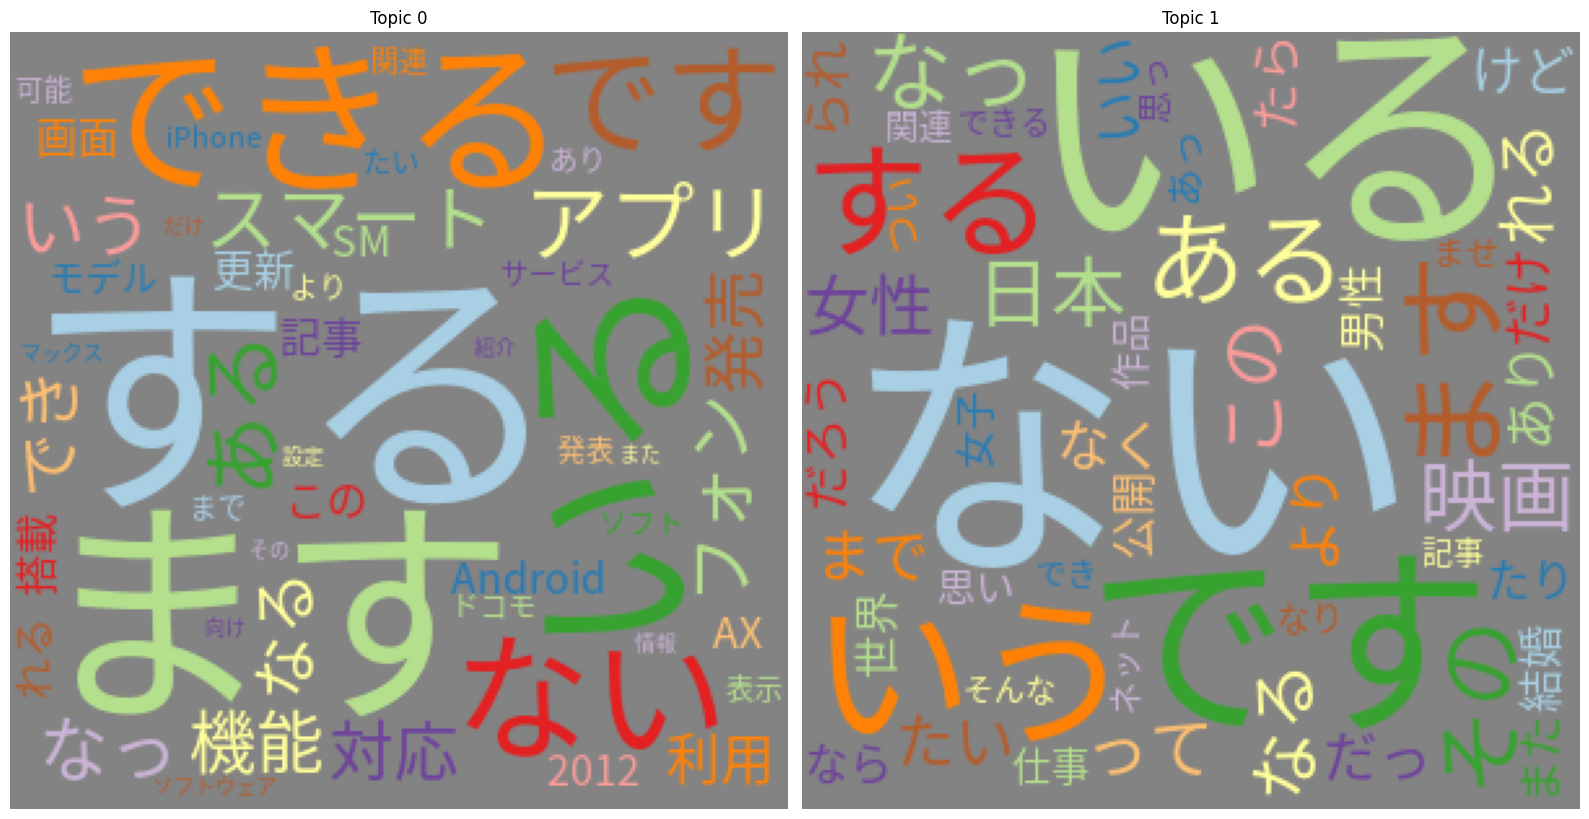

In [20]:
import matplotlib.pylab as plt
import math
from wordcloud import WordCloud

fig, axs = plt.subplots(ncols=2, nrows=math.ceil(model.num_topics/2), figsize=(16,20))
axs = axs.flatten()

def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

for i, t in enumerate(range(model.num_topics)):

    x = dict(model.show_topic(t, 50))
    im = WordCloud(
        background_color='gray',
        color_func=color_func,
        font_path=f'{prefix_files}/NotoSansJP-Regular.otf',
        # font_path='../../NotoSansJP-Regular.otf',
        max_words=4000,
        width=300, height=300,
        random_state=0
    ).generate_from_frequencies(x)
    axs[i].imshow(im.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(t))

# vis
plt.tight_layout()
plt.show()

# word2vecの学習
- BoWは使いません。
- ```__iter__```を定義したオブジェクトを使います。1文が```list[str]```で表現されています。
- 辞書は内部で作成してくれます。
- ```min_count=1```は少なくとも１回は出現している単語に制限するオプションです。

In [10]:
class WVCorpus():
    def __init__(self, corpus):
        self.corpus = corpus
    def __iter__(self):
        return iter(self.corpus)

sentences = WVCorpus(corpus.raw_documents)
# instantiating and training the Word2Vec model
model_wv = models.Word2Vec(
    sentences,
    min_count=1,
    compute_loss=True,
    hs=0,
    sg=1,
    seed=42,
)

# getting the training loss value
training_loss = model_wv.get_latest_training_loss()
print(training_loss)

2023-01-28 00:16:29,136 : INFO : collecting all words and their counts
2023-01-28 00:16:29,137 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-01-28 00:16:29,432 : INFO : collected 71140 word types from a corpus of 2070594 raw words and 7367 sentences
2023-01-28 00:16:29,432 : INFO : Creating a fresh vocabulary
2023-01-28 00:16:29,550 : DEBUG : starting a new internal lifecycle event log for Word2Vec
2023-01-28 00:16:29,550 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 71140 unique words (100.00% of original 71140, drops 0)', 'datetime': '2023-01-28T00:16:29.550192', 'gensim': '4.3.0', 'python': '3.9.6 (default, Sep 26 2022, 11:37:49) \n[Clang 14.0.0 (clang-1400.0.29.202)]', 'platform': 'macOS-12.5.1-arm64-arm-64bit', 'event': 'prepare_vocab'}
2023-01-28 00:16:29,550 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 2070594 word corpus (100.00% of original 2070594, drops 0)', 'datetime': '2023-01-28T00:16:

29867240.0


### 最も類似している単語を抽出

In [11]:
model_wv.wv.most_similar('合コン')

[('飲み会', 0.7732919454574585),
 ('デート', 0.7488614916801453),
 ('誘い', 0.7443931102752686),
 ('意中', 0.7424918413162231),
 ('ホンネ', 0.7244622707366943),
 ('OL', 0.7169602513313293),
 ('フラ', 0.7154644727706909),
 ('幹事', 0.7129135131835938),
 ('下ネタ', 0.71234130859375),
 ('割り勘', 0.7095178961753845)]

### word2vecの辞書

In [13]:
for index, word in enumerate(model_wv.wv.index2word):
    if index == 10:
        break
    print(f"word #{index}/{len(model_wv.wv.index2word)} is {word}")

word #0/71140 is する
word #1/71140 is いる
word #2/71140 is ない
word #3/71140 is ます
word #4/71140 is です
word #5/71140 is いう
word #6/71140 is ある
word #7/71140 is なっ
word #8/71140 is その
word #9/71140 is なる


### 単語間の類似度を計算

In [14]:
pairs = [
    ('iPhone', 'Android'),
    ('iPhone', '新聞'),
    ('iPhone', 'パソコン'),
    ('iPhone', '時計'),
]
for w1, w2 in pairs:
    print(f"{w1}, {w2}, {model_wv.wv.similarity(w1, w2)}")

iPhone, Android, 0.4729384183883667
iPhone, 新聞, 0.33516553044319153
iPhone, パソコン, 0.3927516043186188
iPhone, 時計, 0.36304032802581787


### その他

In [15]:
# 新聞に似ている単語トップ５
print(model_wv.wv.most_similar(positive=['新聞'], topn=5))
# 新聞かニュースかに似ている単語トップ５
print(model_wv.wv.most_similar(positive=['新聞', 'ニュース'], topn=5))
# 次のリストの中で仲間はずれはどれでしょう？
print(model_wv.wv.doesnt_match(['新聞', '産経', '読売', '日経', '毎日', '今週']))

2023-01-28 00:20:36,943 : WARNING : vectors for words {'毎日'} are not present in the model, ignoring these words


[('産経', 0.8054088950157166), ('虚構', 0.774670422077179), ('読売', 0.7574974894523621), ('朝刊', 0.721294105052948), ('報道', 0.7096503376960754)]
[('産経', 0.8009508848190308), ('虚構', 0.769353985786438), ('報じる', 0.7210793495178223), ('FNN', 0.7029671669006348), ('朝刊', 0.7016972303390503)]
今週
